In [1]:
# install packages in libs (as editable)
!python -m pip install -e ../libs

Obtaining file:///Users/n0c09jf/code/github/binsense/libs
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for binsense-libs (pyproject.toml) ... done
  Created wheel for binsense-libs: filename=binsense_libs-0.0.1-py2.py3-none-any.whl size=1137 sha256=8524b93cea3793ac8f93136a46b3b775f211868867a04c7e319690205c497b92
  Stored in directory: /private/var/folders/vm/2g2pvy116zzglvllmm0n_f100000gx/T/pip-ephem-wheel-cache-88b0zu63/wheels/77/72/16/1e76e1dcd0e567ae2a1096c6d731674e5dee84ed8ab15b770d
Successfully built binsense-libs
  Attempting uninstall: binsense-libs
    Found existing installation: binsense-libs 0.0.1
    Uninstalling binsense-libs-0.0.1:
      Successfully uninstalled binsense-libs-0.0.1


In [ ]:
from binsense.config import DATA_DIR
print(DATA_DIR)

import binsense.dataprep.downloader as d
d.download()

import binsense.dataprep.metadata as m
bin_df, item_df = m.load()
print(bin_df.shape, item_df.shape)


In [3]:
from binsense.owlv2 import hugg_loader as l
from binsense.owlv2 import Owlv2Config
from binsense.owlv2 import Owlv2ForObjectDetection, Owlv2ImageProcessor
import numpy as np

processor = Owlv2ImageProcessor(**l.load_owlv2processor_config())
model = Owlv2ForObjectDetection(Owlv2Config(**l.load_owlv2model_config()))
model.load_state_dict(l.load_owlv2model_statedict())
model.eval()
print()

In [27]:
import torch
import PIL

from binsense.config import BIN_S3_DOWNLOAD_IMAGES_DIR as imgdir
from scipy.special import expit as sigmoid

def get_topk_bboxes(image_path, topk):
    sample_image = PIL.Image.open(image_path)
    image_pixels = processor.preprocess(sample_image)['pixel_values']

    with torch.no_grad():
        image_embeds, _ = model.image_embedder(image_pixels)
        bbox_logits  = model.objectness_predictor(image_embeds)
        bboxes = model.box_predictor(image_embeds)
        # print('embeds=', image_embeds.shape, ', bbox_logits=', bbox_logits.shape, ', bboxes=',  bboxes.shape)
        
    padded_item_image = PIL.Image.fromarray(processor.unnormalize_pixels(image_pixels)[0])
    target_sizes = torch.Tensor([padded_item_image.size[::-1]])
    boxes = processor.post_process_bounding_boxes(boxes=bboxes, target_sizes=target_sizes)
    boxes = np.array(boxes[0].detach())
    objectnesses = np.array(bbox_logits[0].detach())

    # Plot top k objects on Query Item Image
    topk_boxscores = []
    
    objectnesses = sigmoid(objectnesses)
    topk_objectness = sorted([(i, score) for i, score in enumerate(objectnesses)], key=lambda x: x[1], reverse=True)[:topk]
    # objectness_threshold = np.partition(objectnesses, -topk)[-topk]

    for i, score in topk_objectness:
        # if objectness < objectness_threshold:
        #     continue
        topk_boxscores.append((boxes[i], score))
        
    return padded_item_image, topk_boxscores

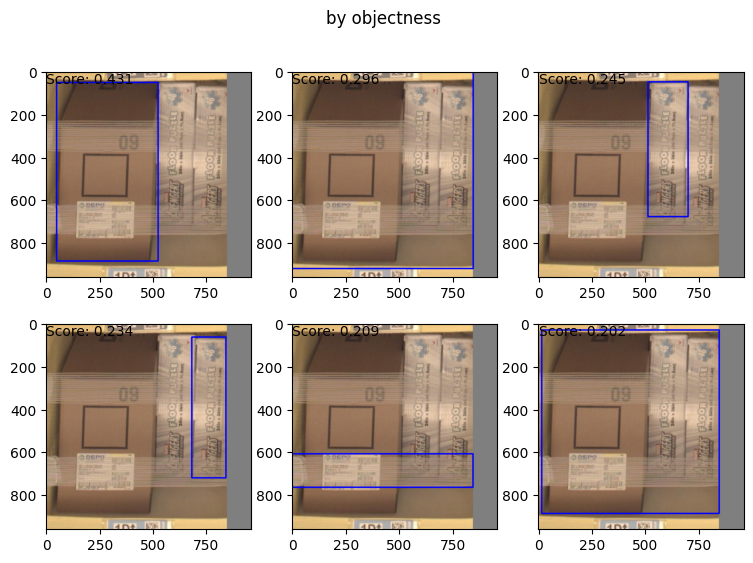

In [28]:
from binsense.plot_utils import show_bbox_ingrid

img, box_scores = get_topk_bboxes('../docs/sample_bin.jpg', 6)
show_bbox_ingrid(np.array(img), box_scores, grid=(2, 3), title="by objectness")

## Check the DETRMultiBoxLossWithoutLabel
1. get an image with bounding boxes
3. check the loss with a bounding box at different positions

In [1]:
from binsense.dataset_util import Yolov8Deserializer, DataTag
from binsense.dataprep.config import DataPrepConfig

from binsense.embed_datastore import SafeTensorEmbeddingDatastore
from binsense.lightning.owl_wrappper import DETRMultiBoxLossWithoutLabel

cfg = DataPrepConfig()
ds = Yolov8Deserializer(cfg.filtered_dataset_path, img_extns=['.jpg']).read()

sampleimg_name = 02067.jpg
4 --> [[169 123 283 531]
 [355 104 429 528]
 [  0 215 176 533]
 [275 109 370 528]]


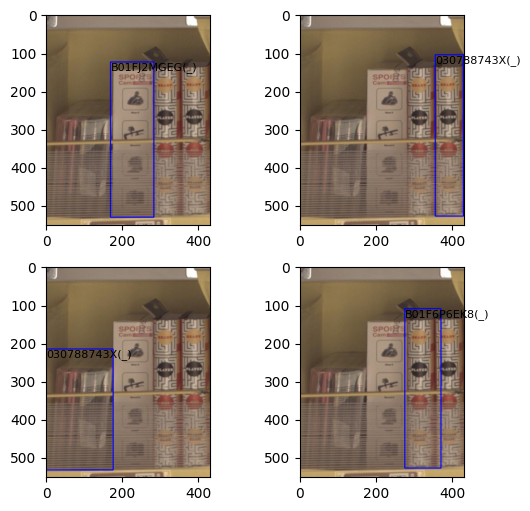

In [2]:
from binsense.img_utils import center_to_corners, scale_bboxes, corner_to_centers
from binsense.plot_utils import show_bbox_ingrid
from torchvision.ops import generalized_box_iou

import numpy as np
import random, PIL, torch

train_imgs = ds.get_images(DataTag.TRAIN)
sampleimg = random.choice(train_imgs)
print(f"sampleimg_name = {sampleimg.name}")

sampleimg_name = "04025.jpg"
sampleimg = ds._get_image(sampleimg_name)
bboxes = ds.get_bboxes(sampleimg.name)

sampleimg_pil = PIL.Image.open(sampleimg.path)
labels = np.array([bbox.label for bbox in bboxes])
gt_cxy_bboxes = np.array([bbox.to_array() for bbox in bboxes])
gt_xy_bboxes = scale_bboxes(
    center_to_corners(gt_cxy_bboxes),
    (sampleimg_pil.width, sampleimg_pil.height)
)
print(gt_xy_bboxes.shape[0], "-->", gt_xy_bboxes)
show_bbox_ingrid(
    cv_img=np.array(sampleimg_pil),
    box_scores=list(zip(gt_xy_bboxes, [None]*len(labels), labels)),
    grid=(2, 2)
)


## generalize IOU

tensor([[ 0.1175, -0.0683, -0.3668,  0.5638]])


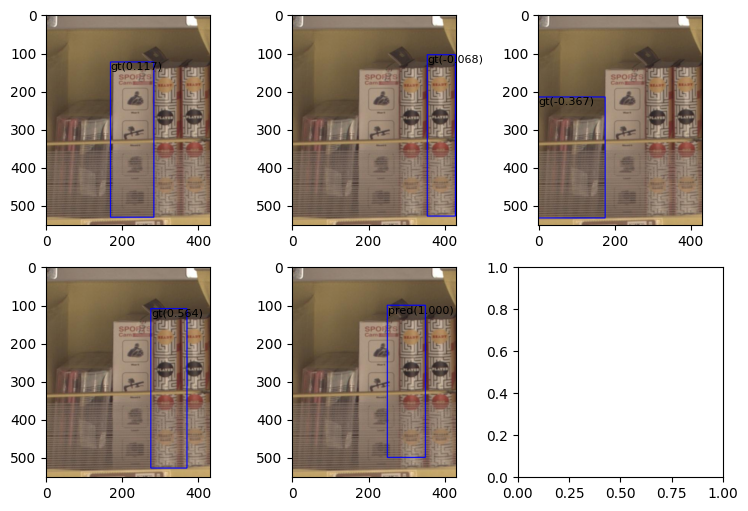

In [3]:
from binsense.img_utils import center_to_corners, scale_bboxes, corner_to_centers
from binsense.plot_utils import show_bbox_ingrid
from torchvision.ops import generalized_box_iou, box_iou

import numpy as np
import random, PIL, torch

pred_xy_bbox = np.array([[250, 100, 350, 500]], dtype=np.int32)
pred_cxy_bbox = np.copy(pred_xy_bbox).astype(dtype=np.float32)
pred_cxy_bbox = corner_to_centers(pred_cxy_bbox)
pred_cxy_bbox[:,[0, 2]] = pred_cxy_bbox[:,[0, 2]] / sampleimg_pil.width
pred_cxy_bbox[:,[1, 3]] = pred_cxy_bbox[:,[1, 3]] / sampleimg_pil.height

iou = generalized_box_iou(torch.as_tensor(pred_xy_bbox), torch.as_tensor(gt_xy_bboxes))
# iou = box_iou(torch.as_tensor(pred_xy_bbox), torch.as_tensor(gt_xy_bboxes))
print(iou)
box_scores = [(b, round(iou[0][i].item(), 3), 'gt') for i, b in enumerate(gt_xy_bboxes)]
box_scores.append((pred_xy_bbox[0], 1, 'pred'))

show_bbox_ingrid(
    cv_img=np.array(sampleimg_pil),
    box_scores=box_scores,
    grid=(2, 3)
)

## DETRMultiBox Loss

In [8]:
from binsense.owlv2.config import Owlv2Config
from binsense.owlv2.model import Owlv2ForObjectDetection
from binsense.owlv2.processor import Owlv2ImageProcessor
from binsense.owlv2 import hugg_loader as hloader

# load the embedding store created by above run & check for few embeddings
embed_ds = SafeTensorEmbeddingDatastore(
    cfg.embed_store_dirpath, 
    read_only=True
)

processor = Owlv2ImageProcessor()
owl_model_cfg = Owlv2Config(**hloader.load_owlv2model_config())
model = Owlv2ForObjectDetection(owl_model_cfg)
model.load_state_dict(hloader.load_owlv2model_statedict())

query_label = bboxes[1].label
print(query_label, embed_ds.has(query_label))

if not embed_ds.has(query_label):
    raise ValueError('the query label is missing!! check the embed datastore.')
    
query_embedding = embed_ds.get(query_label)
assert query_embedding.shape == torch.Size([512])

target_embeds = processor.preprocess(sampleimg_pil)['pixel_values']
output = model(target_embeds, query_embedding)

pred_boxes = output[1]
pred_logits = output[2]


030788743X True


AssertionError: 

In [5]:
labels = [k for k in embed_ds.get_keys()]
(query_label in labels)

True

In [ ]:
from binsense.lightning.owl_wrappper import DETRMultiBoxLossWithoutLabel

loss_fn = DETRMultiBoxLossWithoutLabel()
loss_fn({"pred_boxes": pred_boxes, "pred_logits": pred_logits}, {"boxes": [gt_cxy_bboxes[[1, 3]]]})